# Multiclass Image detection: Electronics Components

## Overview

The purpose of this notebook is to analyze the data and make a multiclass image detection model to determine which electronic component is shown on the input image.

The training data is available in [kaggle](https://www.kaggle.com/datasets/olavomendes/elec-dataset)

It contains images labeled as one of the 5 classes we are interested in (led, potentiometer, push_button, resistor or ultrasonic sensor)


In [167]:
import tensorflow as tf
from tensorflow import keras
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

import fnmatch, os
import numpy as np

Let's start by analyzing how many images we have per label, per set (training, testing). We can do this by counting the number of files in each directory/label. In the process, we can also view a few samples of each, including the image size.

train_set-ultrasonic_sensor:149
train_set-potentiometer:150
train_set-push_button:150
train_set-resistor:150
train_set-led:150
test_set-ultrasonic_sensor:50
test_set-potentiometer:49
test_set-push_button:49
test_set-resistor:49
test_set-led:49


<Figure size 2200x2200 with 0 Axes>

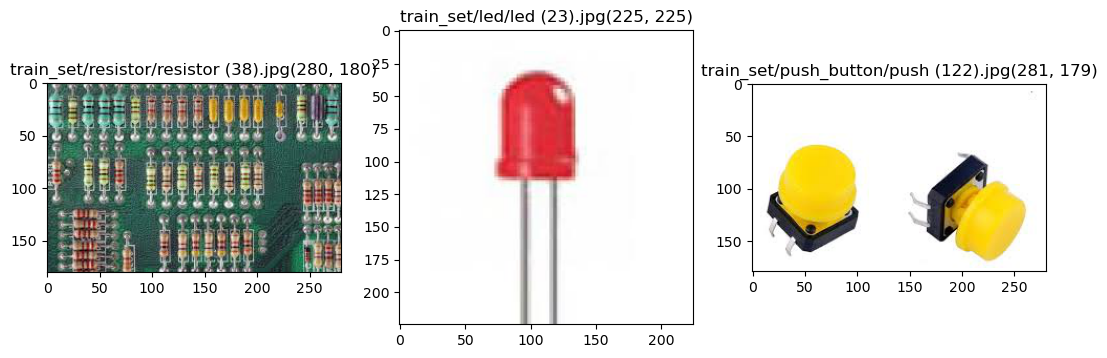

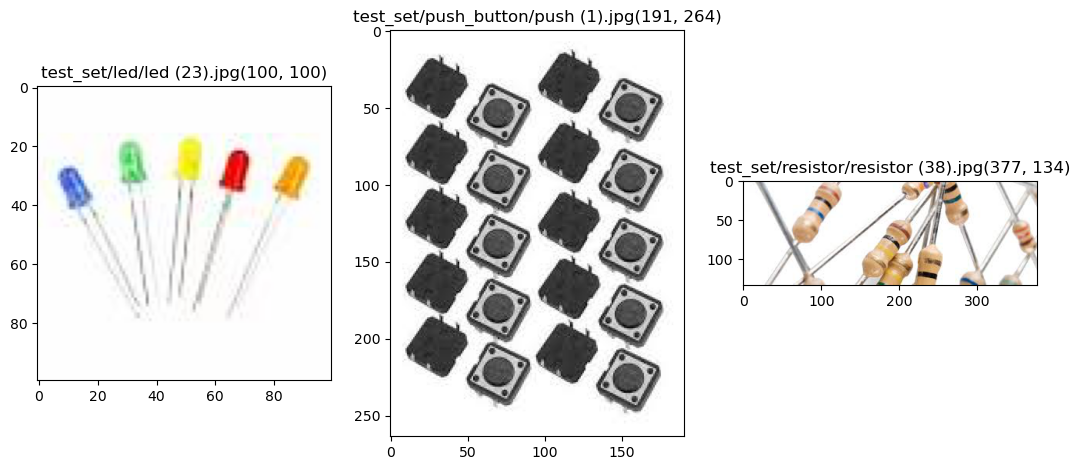

In [168]:
input_path = 'electronics_dataset/'

images_count={"train_set":{}, "test_set":{}}

samples=53
i=1
for (root,dirs,files) in os.walk(input_path, topdown=True):
    path=root.split("/");
    if len(path)<=2:
        plt.figure(figsize=(22,22))
    if len(path)>2:
        images_count[path[1]][path[2]]=len(files)
        print (path[1]+"-"+path[2]+":"+str(images_count[path[1]][path[2]]))
        # load the image
        image_filename=input_path+path[1]+"/"+path[2]+"/"+files[0]
        img = load_img(image_filename)
        plt.subplot(1,5,i)
        plt.imshow(img)
        plt.title(image_filename[len(input_path):] + str(img.size))
        i=i+1
        if i>3:
            i=1


We can see we have about 150 images for training for each category, and for testing we have approx 50 per each. 

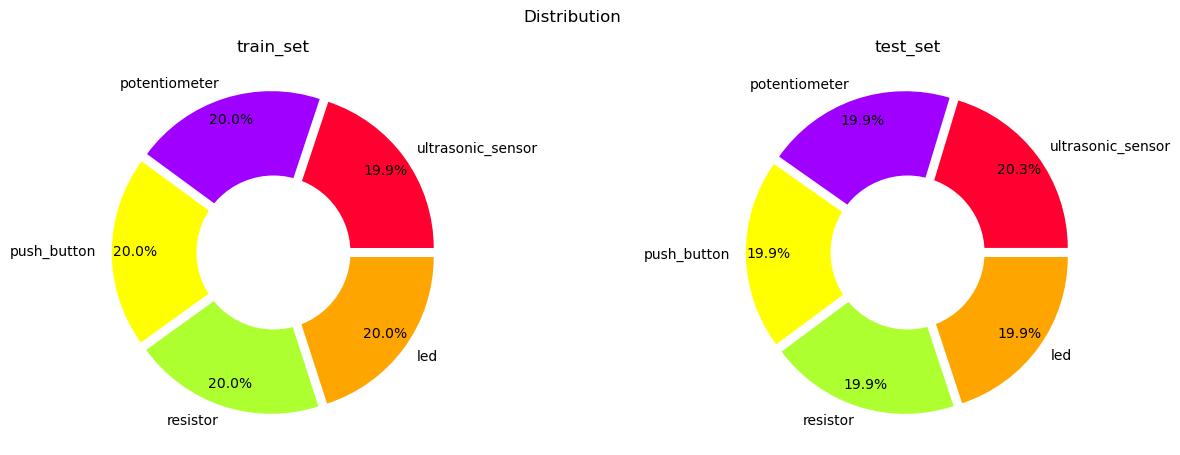

In [169]:
def draw_donut_chart(set_to_draw, pos):

    colors = ['#FF0030', '#A000FF', '#FFFF00', 
              '#ADFF2F', '#FFA500']
    explode = (0.05, 0.05, 0.05, 0.05, 0.05)

    plt.subplot(1, 2, pos)
    plt.pie(list(images_count[set_to_draw].values()), colors=colors, labels=list(images_count[set_to_draw].keys()),
            autopct='%1.1f%%', pctdistance=0.85,
            explode=explode)

    # draw circle
    centre_circle = plt.Circle((0, 0), 0.50, fc='white')
    fig = plt.gcf()

    # Adding Circle in Pie chart
    fig.gca().add_artist(centre_circle)

    # Adding Title of chart
    plt.title(set_to_draw)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Distribution')

draw_donut_chart ("train_set", 1)
draw_donut_chart ("test_set", 2)

We can see that the distribution is quite even for all categories and for both training and testing

Our dataset has already neatly separated training, test, and validation samples. In the code below, we construct a Keras data object for the training and validation sets using `keras.preprocessing.image_dataset_from_directory`. We chose the Adam optimizer and set the learning rate to 0.02. We train our classifier using the ResNet50 architecture, which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. It learns from each image, updates the model gradients, and gradually improves its performance. The model is compiled, trained, and saved in `model/keras_single/`.

We will be doing transfer learning based off of the Xception model

In [170]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions


from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [171]:
image_size = (150, 150)
batch_size = 32
number_of_categories=5

In [172]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    input_path+"train_set",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 749 images belonging to 5 classes.


In [173]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    input_path+"test_set",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 246 images belonging to 5 classes.


In [174]:
base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False               # deep layers will not be kept (they will be calculated!)
)

base_model.trainable = False        # convolution layers will not be changed

In [175]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(number_of_categories)(vector)

model = keras.Model(inputs, outputs)

In [176]:
learning_rate = 0.01

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [177]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
24/24 [==============================] - 5s 105ms/step - loss: 0.4711 - accuracy: 0.8518 - val_loss: 0.2860 - val_accuracy: 0.9187
Epoch 2/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0646 - accuracy: 0.9760 - val_loss: 0.2078 - val_accuracy: 0.9390
Epoch 3/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0313 - accuracy: 0.9920 - val_loss: 0.2136 - val_accuracy: 0.9431
Epoch 4/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0227 - accuracy: 0.9893 - val_loss: 0.2956 - val_accuracy: 0.9268
Epoch 5/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0079 - accuracy: 0.9973 - val_loss: 0.2598 - val_accuracy: 0.9350
Epoch 6/10
24/24 [==============================] - 2s 74ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.2539 - val_accuracy: 0.9431
Epoch 7/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2575 - val_accuracy: 0.9268
Epoch 8/10
2

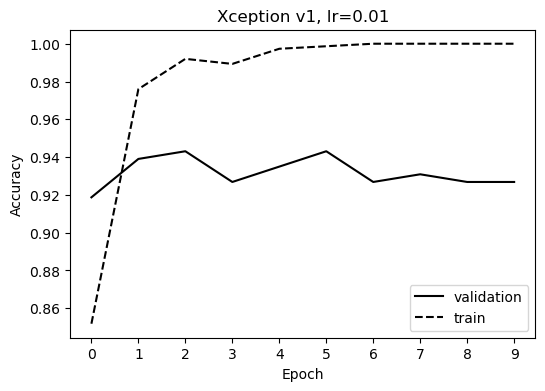

In [178]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


plt.savefig('xception_v1_0_01.svg')

plt.show()

In [179]:
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(number_of_categories)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [180]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
24/24 [==============================] - 5s 105ms/step - loss: 0.8238 - accuracy: 0.7063 - val_loss: 0.4756 - val_accuracy: 0.8496
Epoch 2/10
24/24 [==============================] - 2s 73ms/step - loss: 0.2586 - accuracy: 0.9292 - val_loss: 0.3268 - val_accuracy: 0.8862
Epoch 3/10
24/24 [==============================] - 2s 73ms/step - loss: 0.1701 - accuracy: 0.9559 - val_loss: 0.2977 - val_accuracy: 0.8984
Epoch 4/10
24/24 [==============================] - 2s 73ms/step - loss: 0.1252 - accuracy: 0.9720 - val_loss: 0.2788 - val_accuracy: 0.8943
Epoch 5/10
24/24 [==============================] - 2s 73ms/step - loss: 0.1011 - accuracy: 0.9840 - val_loss: 0.2703 - val_accuracy: 0.9065
Epoch 6/10
24/24 [==============================] - 2s 74ms/step - loss: 0.0813 - accuracy: 0.9907 - val_loss: 0.2448 - val_accuracy: 0.9106
Epoch 7/10
24/24 [==============================] - 2s 74ms/step - loss: 0.0668 - accuracy: 0.9947 - val_loss: 0.2375 - val_accuracy: 0.9106
Epoch 8/10
2

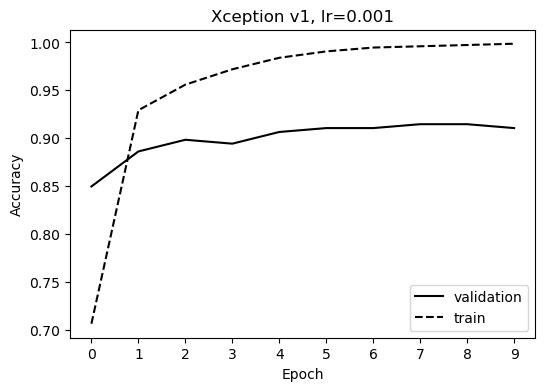

In [181]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_001.svg')

plt.show()

In [182]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
24/24 [==============================] - 5s 106ms/step - loss: 1.6783 - accuracy: 0.2830 - val_loss: 1.4568 - val_accuracy: 0.3171
Epoch 2/10
24/24 [==============================] - 2s 73ms/step - loss: 1.2958 - accuracy: 0.4593 - val_loss: 1.1860 - val_accuracy: 0.5569
Epoch 3/10
24/24 [==============================] - 2s 74ms/step - loss: 1.0482 - accuracy: 0.6342 - val_loss: 0.9922 - val_accuracy: 0.6951
Epoch 4/10
24/24 [==============================] - 2s 73ms/step - loss: 0.8721 - accuracy: 0.7477 - val_loss: 0.8536 - val_accuracy: 0.7764
Epoch 5/10
24/24 [==============================] - 2s 74ms/step - loss: 0.7406 - accuracy: 0.8091 - val_loss: 0.7520 - val_accuracy: 0.8089
Epoch 6/10
24/24 [==============================] - 2s 74ms/step - loss: 0.6433 - accuracy: 0.8425 - val_loss: 0.6720 - val_accuracy: 0.8374
Epoch 7/10
24/24 [==============================] - 2s 75ms/step - loss: 0.5690 - accuracy: 0.8665 - val_loss: 0.6122 - val_accuracy: 0.8577
Epoch 8/10
2

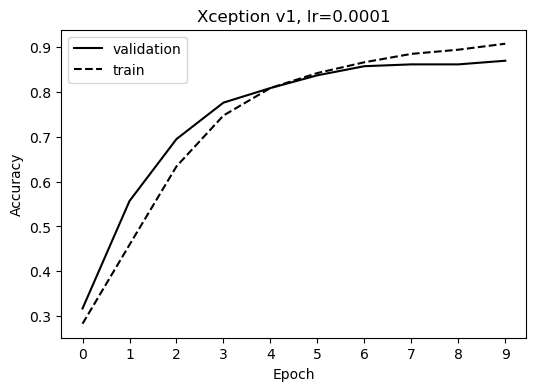

In [183]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_0001.svg')

plt.show()

In [184]:
epochs = np.arange(10)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

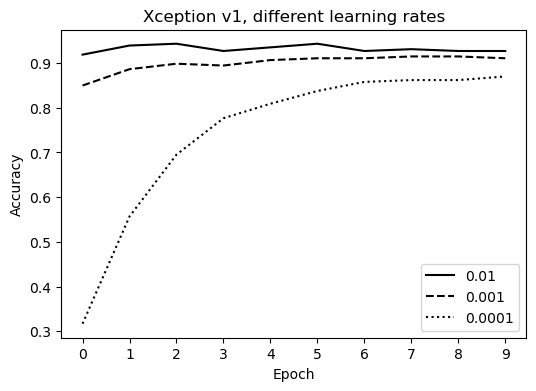

In [185]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('Xception v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('xception_v1_all_lr.svg')

plt.show()

In [186]:
model = make_model(learning_rate=0.001)


In [187]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
24/24 [==============================] - 5s 118ms/step - loss: 0.8777 - accuracy: 0.6916 - val_loss: 0.4080 - val_accuracy: 0.8699
Epoch 2/10
24/24 [==============================] - 2s 85ms/step - loss: 0.2550 - accuracy: 0.9359 - val_loss: 0.3275 - val_accuracy: 0.8821
Epoch 3/10
24/24 [==============================] - 2s 85ms/step - loss: 0.1744 - accuracy: 0.9559 - val_loss: 0.2603 - val_accuracy: 0.9024
Epoch 4/10
24/24 [==============================] - 2s 75ms/step - loss: 0.1271 - accuracy: 0.9760 - val_loss: 0.2380 - val_accuracy: 0.9024
Epoch 5/10
24/24 [==============================] - 2s 75ms/step - loss: 0.1029 - accuracy: 0.9826 - val_loss: 0.2565 - val_accuracy: 0.9024
Epoch 6/10
24/24 [==============================] - 2s 87ms/step - loss: 0.0834 - accuracy: 0.9907 - val_loss: 0.2199 - val_accuracy: 0.9065
Epoch 7/10
24/24 [==============================] - 2s 86ms/step - loss: 0.0682 - accuracy: 0.9933 - val_loss: 0.2099 - val_accuracy: 0.9106
Epoch 8/10
2

In [188]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(number_of_categories)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [189]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 5s 120ms/step - loss: 0.5027 - accuracy: 0.8144 - val_loss: 0.2788 - val_accuracy: 0.9106
Epoch 2/30
24/24 [==============================] - 2s 86ms/step - loss: 0.1085 - accuracy: 0.9613 - val_loss: 0.1741 - val_accuracy: 0.9268
Epoch 3/30
24/24 [==============================] - 2s 86ms/step - loss: 0.0489 - accuracy: 0.9880 - val_loss: 0.1624 - val_accuracy: 0.9350
Epoch 4/30
24/24 [==============================] - 2s 75ms/step - loss: 0.0349 - accuracy: 0.9920 - val_loss: 0.2177 - val_accuracy: 0.9268
Epoch 5/30
24/24 [==============================] - 2s 75ms/step - loss: 0.0184 - accuracy: 0.9987 - val_loss: 0.1707 - val_accuracy: 0.9228
Epoch 6/30
24/24 [==============================] - 2s 75ms/step - loss: 0.0118 - accuracy: 0.9987 - val_loss: 0.2330 - val_accuracy: 0.9228
Epoch 7/30
24/24 [==============================] - 2s 76ms/step - loss: 0.0093 - accuracy: 0.9987 - val_loss: 0.1872 - val_accuracy: 0.9268
Epoch 8/30
2

In [190]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 5s 120ms/step - loss: 0.5740 - accuracy: 0.7770 - val_loss: 0.2756 - val_accuracy: 0.8943
Epoch 2/30
24/24 [==============================] - 2s 87ms/step - loss: 0.1239 - accuracy: 0.9613 - val_loss: 0.1860 - val_accuracy: 0.9309
Epoch 3/30
24/24 [==============================] - 2s 77ms/step - loss: 0.0586 - accuracy: 0.9853 - val_loss: 0.1810 - val_accuracy: 0.9228
Epoch 4/30
24/24 [==============================] - 2s 76ms/step - loss: 0.0458 - accuracy: 0.9893 - val_loss: 0.2191 - val_accuracy: 0.9146
Epoch 5/30
24/24 [==============================] - 2s 76ms/step - loss: 0.0357 - accuracy: 0.9933 - val_loss: 0.1508 - val_accuracy: 0.9268
Epoch 6/30
24/24 [==============================] - 2s 77ms/step - loss: 0.0234 - accuracy: 0.9973 - val_loss: 0.2357 - val_accuracy: 0.9106
Epoch 7/30
24/24 [==============================] - 2s 76ms/step - loss: 0.0181 - accuracy: 0.9933 - val_loss: 0.1688 - val_accuracy: 0.9309
Epoch 8/30
2

In [191]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 6s 123ms/step - loss: 0.7387 - accuracy: 0.7210 - val_loss: 0.3196 - val_accuracy: 0.8821
Epoch 2/30
24/24 [==============================] - 2s 88ms/step - loss: 0.2510 - accuracy: 0.9119 - val_loss: 0.3160 - val_accuracy: 0.9024
Epoch 3/30
24/24 [==============================] - 2s 89ms/step - loss: 0.1477 - accuracy: 0.9533 - val_loss: 0.2143 - val_accuracy: 0.9228
Epoch 4/30
24/24 [==============================] - 2s 89ms/step - loss: 0.1091 - accuracy: 0.9666 - val_loss: 0.1730 - val_accuracy: 0.9309
Epoch 5/30
24/24 [==============================] - 2s 89ms/step - loss: 0.0849 - accuracy: 0.9746 - val_loss: 0.1923 - val_accuracy: 0.9350
Epoch 6/30
24/24 [==============================] - 2s 77ms/step - loss: 0.0582 - accuracy: 0.9800 - val_loss: 0.2093 - val_accuracy: 0.9268
Epoch 7/30
24/24 [==============================] - 2s 77ms/step - loss: 0.0524 - accuracy: 0.9893 - val_loss: 0.1811 - val_accuracy: 0.9350
Epoch 8/30
2

In [192]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 5s 123ms/step - loss: 1.2616 - accuracy: 0.5087 - val_loss: 0.5197 - val_accuracy: 0.8496
Epoch 2/30
24/24 [==============================] - 2s 89ms/step - loss: 0.6686 - accuracy: 0.7356 - val_loss: 0.3589 - val_accuracy: 0.8943
Epoch 3/30
24/24 [==============================] - 2s 89ms/step - loss: 0.5661 - accuracy: 0.7784 - val_loss: 0.2806 - val_accuracy: 0.9024
Epoch 4/30
24/24 [==============================] - 2s 89ms/step - loss: 0.4471 - accuracy: 0.8291 - val_loss: 0.2662 - val_accuracy: 0.9106
Epoch 5/30
24/24 [==============================] - 2s 89ms/step - loss: 0.3906 - accuracy: 0.8505 - val_loss: 0.2313 - val_accuracy: 0.9268
Epoch 6/30
24/24 [==============================] - 2s 78ms/step - loss: 0.3513 - accuracy: 0.8571 - val_loss: 0.2148 - val_accuracy: 0.9146
Epoch 7/30
24/24 [==============================] - 2s 78ms/step - loss: 0.2942 - accuracy: 0.8879 - val_loss: 0.2096 - val_accuracy: 0.9187
Epoch 8/30
2

In [193]:
epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

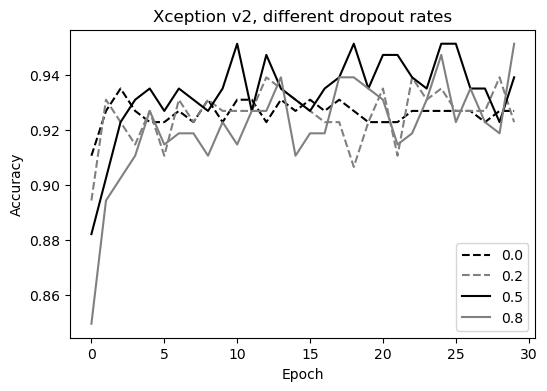

In [194]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

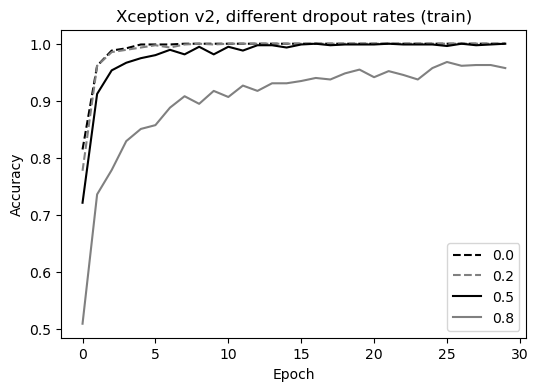

In [195]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()

In [196]:
def train_model_fit(n_epochs, base_lr, batchsize, classes):

    model = tf.keras.applications.ResNet50(include_top=True, weights=None, classes=classes)

    # Data
    train_ds = (
        tf.keras.preprocessing.image_dataset_from_directory(
            input_path+"train_set", image_size=(224, 224), batch_size=batchsize
        )
        .prefetch(2)
        .cache()
        .shuffle(1000)
    )
    # printing sample birds images
    for birds, labels in train_ds.take(1):
        plt.figure(figsize=(18, 18))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(birds[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

    valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
        input_path+"test_set", image_size=(224, 224), batch_size=batchsize
    ).prefetch(2)

    optimizer = keras.optimizers.Adam(lr=base_lr)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    start = time.time()

    model.fit(
        train_ds,
        epochs=n_epochs,
        validation_data=valid_ds,
    )
    end = time.time() - start
    print("model training time", end)

    tf.keras.models.save_model(model, "model/keras_single/")

In the code below, we set up the necessary parameters. We run only a few epochs to save time. But once you've got this model working, you'll have all the information you need to build and run bigger TensorFlow models on Saturn Cloud. A single GPU reviews all our batches every epoch. In this case, it sees 64 images per batch x 640 batches x 3 epochs. These batches are all computed serially; the calculations cannot be parallelized because only one processor is utilized. 

In [197]:
model_params = {"n_epochs": 3, "base_lr": 0.02, "classes": 61, "batchsize": 64}

The code below runs the model training process and saves your trained model object to the Jupyter instance memory. A folder called `model` will be created and populated for you. Also, when you run the training function, you can see some beautiful birds of various species!

Found 749 files belonging to 5 classes.


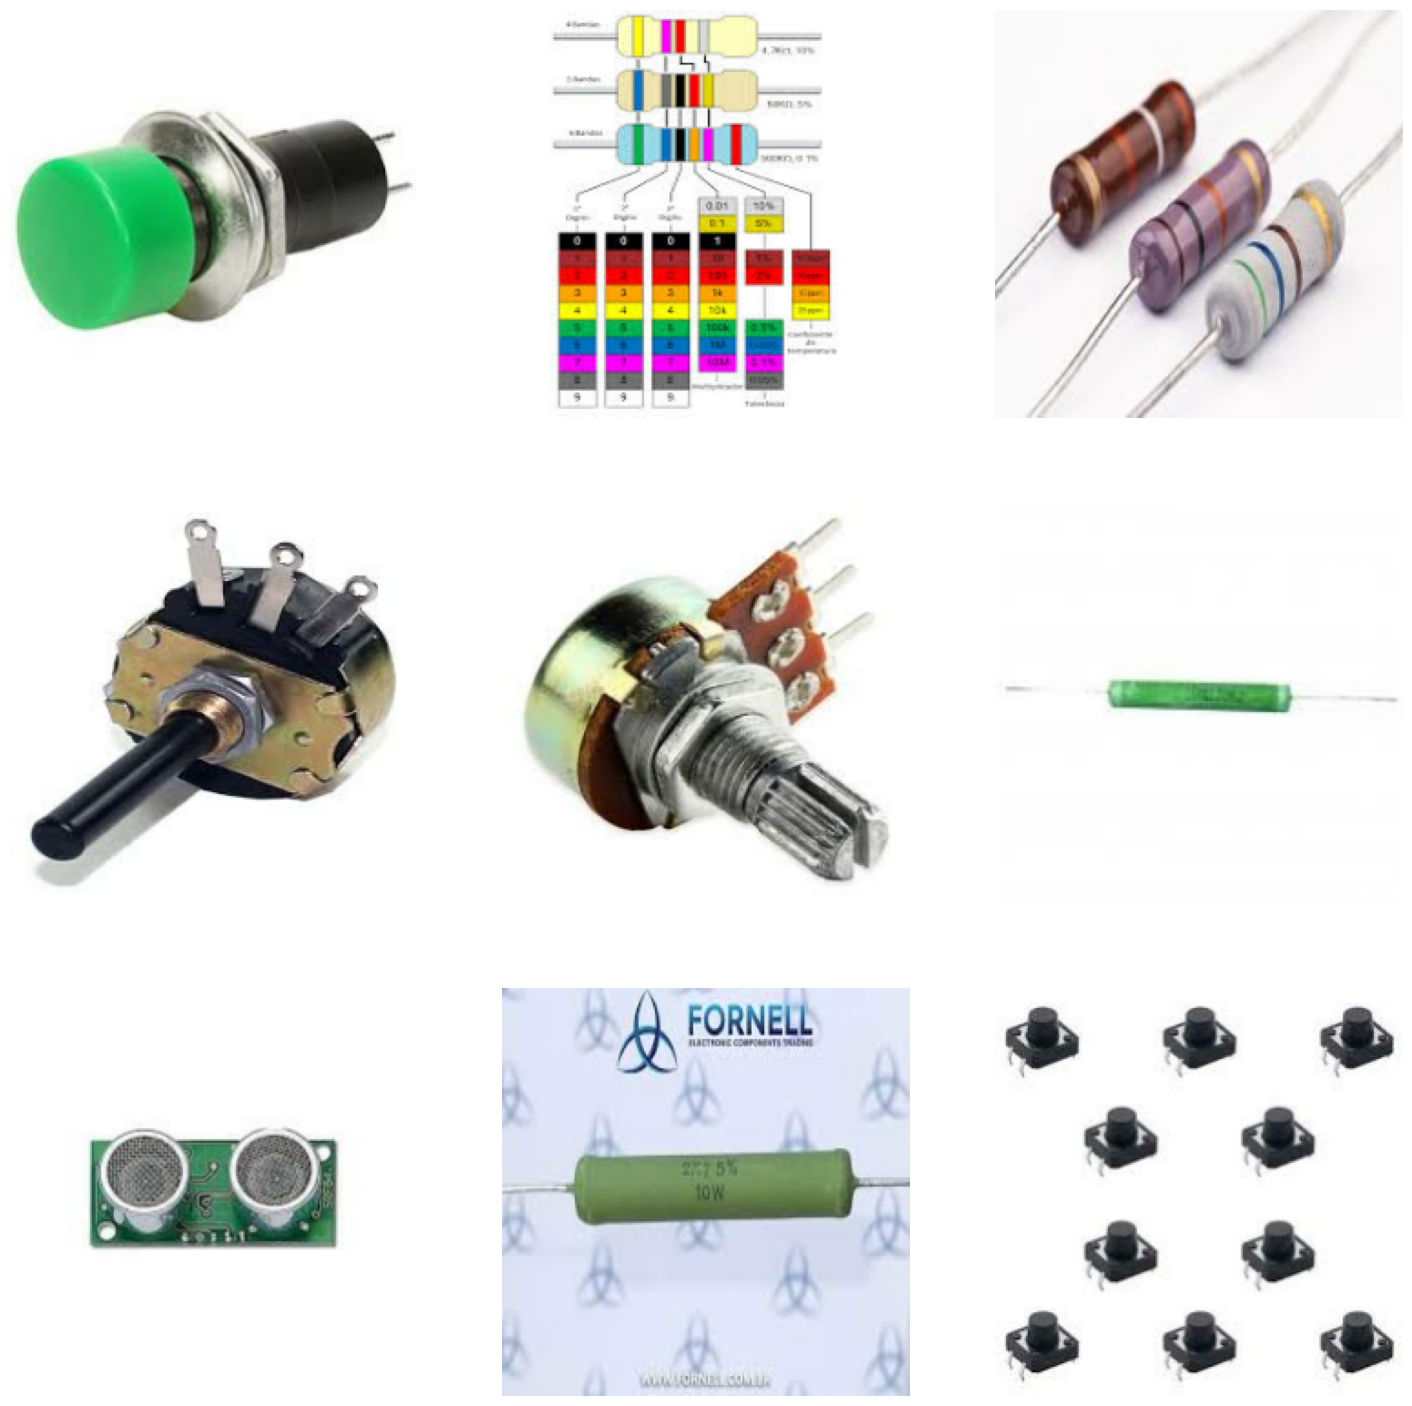

Found 246 files belonging to 5 classes.
Epoch 1/3


/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - 13s 721ms/step - loss: 5.8488 - accuracy: 0.2069 - val_loss: 4794042959789106921472.0000 - val_accuracy: 0.1992
Epoch 2/3
12/12 [==============================] - 8s 642ms/step - loss: 3.7086 - accuracy: 0.3111 - val_loss: 581030920762786054144.0000 - val_accuracy: 0.2114
Epoch 3/3
12/12 [==============================] - 8s 645ms/step - loss: 2.3711 - accuracy: 0.3672 - val_loss: 418989487247327232.0000 - val_accuracy: 0.1992
model training time 28.57122778892517


INFO:tensorflow:Assets written to: model/keras_single/assets


INFO:tensorflow:Assets written to: model/keras_single/assets


In [198]:
tester = train_model_fit(**model_params)